# <center> Предсказание победителя в Dota 2
<center> <img src="https://248006.selcdn.ru/main/iblock/d52/d523440eddffa606bcf4e78a5011a822/2ef90fdbc3e9306a45851dca974be243.jpg" width="700" height="700">

### Импорты

In [1]:
import os
import ujson as json
import pandas as pd
import datetime
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IProgress
import lightgbm

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "./Data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

#### Обучим случайный лес

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: total: 26.6 s
Wall time: 2.93 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-08_23-07-38.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [15]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [16]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: total: 2min 15s
Wall time: 15.8 s


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

In [19]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)

In [20]:
match

{'game_time': 2049,
 'match_id_hash': '75112757bde649d5cff1c7cd4f1275c6',
 'teamfights': [{'start': 306.755,
   'end': 338.551,
   'last_death': 323.454,
   'deaths': 3,
   'players': [{'deaths_pos': {},
     'ability_uses': {'lich_frost_nova': 2, 'lich_dark_ritual': 1},
     'item_uses': {},
     'killed': {'npc_dota_hero_faceless_void': 114},
     'deaths': 0,
     'buybacks': 0,
     'damage': 383,
     'healing': 0,
     'gold_delta': 336,
     'xp_delta': 440},
    {'deaths_pos': {},
     'ability_uses': {'pudge_meat_hook': 1, 'pudge_rot': 1},
     'item_uses': {'smoke_of_deceit': 1, 'tpscroll': 1},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 458,
     'healing': 0,
     'gold_delta': -10,
     'xp_delta': 76},
    {'deaths_pos': {},
     'ability_uses': {},
     'item_uses': {},
     'killed': {},
     'deaths': 0,
     'buybacks': 0,
     'damage': 0,
     'healing': 0,
     'gold_delta': 174,
     'xp_delta': 249},
    {'deaths_pos': {},
     'abilit

In [21]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]
#для KDA будем юзать

(0, 5, 5)

In [22]:
(player["kills"] + player["deaths"])/player["assists"]#но только assists мб 0. так что там ниже прибавим в знаменатель 1

1.0

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [23]:
player["ability_uses"]#они ж все разные для разных персонажей

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

In [24]:
player["hero_id"]#герои кодируются цифрами, но по смыслу это категория

83

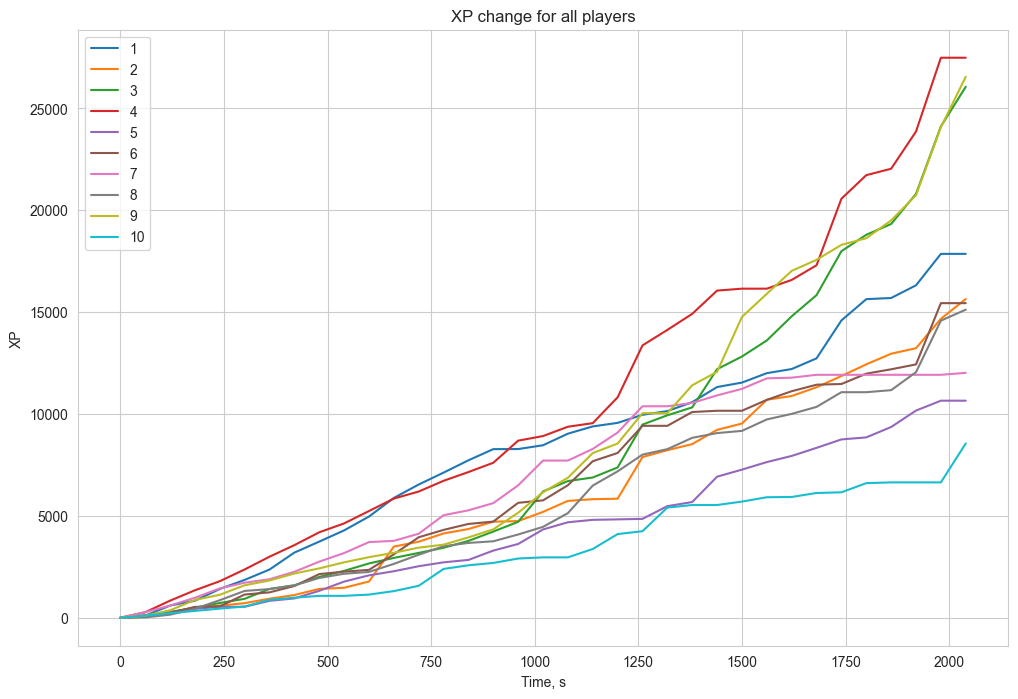

In [25]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [26]:
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [27]:
def add_new_features(df_features, matches_file):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']
        
        
        #--------вторая версия модели--------

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        #только с этими признаками на кросс-валидации ~0.779

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        
        #--------третья версия модели (сначала обсужденные ранее)--------
        
        #KDA (по идее KDA рассчитывается для каждого отдельного игрока, но ход командного матча всё-таки определяется всеми учасниками команды (даже если один плохо играет, то соратники могут вытянуть),так что давайте считать для каждой команды в матче общий)
        KDAs = []
        for player in match["players"]:
            KDAs.append((player["kills"] + player["assists"])/(player["deaths"] + 1))        
        
        df_features.loc[match_id_hash, "radiant_KDA"] = sum(KDAs[0:5])
        df_features.loc[match_id_hash, "dire_KDA"] = sum(KDAs[5:10])
        #с этими и предыдущими признаками на кросс-валидации ~0.787
        
        #использованные способности (давайте опять-таки просуммируем для всех игроков (из соображений, что чем больше значение, тем значимее она в игре))
        match_ability_score = []
        for player in match["players"]:
            player_ability_score = 0
            for score in player["ability_uses"].values():
                player_ability_score += score
            match_ability_score.append(player_ability_score)      
        
        df_features.loc[match_id_hash, "radiant_ability_uses"] = sum(match_ability_score[0:5])
        df_features.loc[match_id_hash, "dire_ability_uses"] = sum(match_ability_score[5:10])
        #с этими и предыдущими признаками на кросс-валидации ~0.787
        
        #давайте с xp_t поколдуем: будем брать производную, друзья (просто интересно что с такой динамической штукой получится)
        xp_t_ds = []
        for player in match["players"]:
            times = player["times"]
            xp_t_s = player["xp_t"]
            xp_t_d = 0
            for i in range(0, len(times)-1):
                xp_t_d += (xp_t_s[i+1] - xp_t_s[i]) / (times[i+1] - times[i])
            xp_t_ds.append(xp_t_d)
        
        df_features.loc[match_id_hash, "radiant_hp_td"] = sum(xp_t_ds[0:5])#тут я написала hp, но это xp, но заметила уже в конце (проблемы русско/английского восприятия)
        df_features.loc[match_id_hash, "dire_hp_td"] = sum(xp_t_ds[5:10])
        #с этими и предыдущими признаками на кросс-валидации ~0.787
        
        #крч лучше не становится (давайте глянем ниже какие в принципе признаки модельке нравятся)

In [28]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [29]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills,radiant_KDA,dire_KDA,radiant_ability_uses,dire_ability_uses,radiant_hp_td,dire_hp_td
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,2.0,0.0,2.0,20.333333,1.476190,94.0,102.0,269.516667,184.500000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0.0,0.0,0.0,0.000000,0.000000,10.0,4.0,32.366667,30.650000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0,0.0,0.0,0.0,6.416667,10.133333,186.0,161.0,407.083333,411.866667
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,0.0,1.0,-1.0,5.428571,11.333333,140.0,61.0,188.500000,208.133333


In [30]:
%%time
rf_model_ext = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)#давайте разделим базовую и с новыми признаками
#rf_model_ext.fit(X_train, y_train)

cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model_ext, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: total: 219 ms
Wall time: 32.9 s


In [31]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.7871911791201274


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков (0.7720210676055513 -> 0.7871911791201274). A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

### Добавим новые признаки

In [32]:
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))


  0%|          | 0/31698 [00:00<?, ?it/s]

In [33]:
df_test_features_extended.head()#проверяем, что всё правильно

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills,radiant_KDA,dire_KDA,radiant_ability_uses,dire_ability_uses,radiant_hp_td,dire_hp_td
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0.0,0.0,0.0,0.000000,2.000000,7.0,11.0,21.950000,34.166667
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,0,0.0,0.0,0.0,10.500000,0.750000,115.0,82.0,230.166667,184.783333
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0,0.0,0.0,0.0,3.833333,4.500000,87.0,70.0,141.916667,164.350000
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,0,1.0,0.0,1.0,4.833333,10.500000,229.0,101.0,294.183333,275.350000
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,0,0.0,0.0,0.0,10.000000,1.916667,155.0,162.0,322.533333,302.133333


In [34]:
df_test_features_extended.columns[10:50]

Index(['r1_gold', 'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health',
       'r1_max_mana', 'r1_level', 'r1_x', 'r1_y', 'r1_stuns',
       'r1_creeps_stacked', 'r1_camps_stacked', 'r1_rune_pickups',
       'r1_firstblood_claimed', 'r1_teamfight_participation',
       'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed',
       'r1_sen_placed', 'r2_hero_id', 'r2_kills', 'r2_deaths', 'r2_assists',
       'r2_denies', 'r2_gold', 'r2_lh', 'r2_xp', 'r2_health', 'r2_max_health',
       'r2_max_mana', 'r2_level', 'r2_x', 'r2_y', 'r2_stuns',
       'r2_creeps_stacked', 'r2_camps_stacked', 'r2_rune_pickups',
       'r2_firstblood_claimed', 'r2_teamfight_participation',
       'r2_towers_killed'],
      dtype='object')

In [40]:
X_2 = df_train_features_extended.values
y_2 = df_train_targets["radiant_win"].values.astype("int8")

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X_2, y_2, 
                                                      test_size=0.33, 
                                                      random_state=SEED)

In [43]:
lm_model = lightgbm.LGBMClassifier(max_depth=12, n_estimators=500, n_jobs=-1, random_state=SEED)
lm_model.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11176, number of negative: 10061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28050
[LightGBM] [Info] Number of data points in the train set: 21237, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526251 -> initscore=0.105102
[LightGBM] [Info] Start training from score 0.105102


LGBMClassifier(max_depth=12, n_estimators=500, n_jobs=-1, random_state=10801)

In [44]:
y_pred = lm_model.predict_proba(X_valid)[:, 1]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [45]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7923492722151859


In [46]:
X_test = df_test_features_extended.values
y_test_pred = lm_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features_extended.index)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [47]:
submission_filename = "submission.csv"
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission.csv
